# Tutorial: Richardson-Gaudin Models Tutorial

In this tutorial, we will demonstrate the usage of the MoHa package to work with the Picket-Fence Richardson-Gaudin model. 
We will show that the energy levels of the Hamiltonian are evenly spaced and explore phase transitions.

This tutorial demonstrates how to work with Richardson-Gaudin (RG) models using the ModelHamiltonian package, including the standard RG model and the picket-fence variant.

## Introduction

Richardson-Gaudin models are exactly solvable quantum many-body systems that describe interactions between spins in a magnetic field. These models are particularly important in understanding superconductivity and quantum phase transitions.

The Hamiltonian for the standard Richardson-Gaudin model is given by:

$$H = \sum_p (\mu_p^Z - J_{pp}^{eq}) S_p^Z + \sum_{pq} J_{pq}^{eq} S_p^+ S_q^-$$

where:
- $\mu_p^Z$ represents the Zeeman term (external magnetic field)
- $J_{pq}^{eq}$ is the coupling strength between sites $p$ and $q$
- $S_p^Z$ is the spin projection operator
- $S_p^+$ and $S_q^-$ are spin raising and lowering operators

The picket-fence model is a special case with equally spaced energy levels: $\mu_p^Z = p\Delta$, where $\Delta$ is the level spacing.

In [37]:
from moha import HamRG
import numpy as np
import matplotlib.pyplot as plt
from pyscf import fci
from numpy.linalg import eigh

## Part 1: Standard Richardson-Gaudin Model

Let's start by setting up a standard Richardson-Gaudin model with 6 sites and uniform coupling.

In [ ]:
n_sites = 8
g = -0.5  # Coupling strength

# Set up the Zeeman term with arbitrary energy levels
np.random.seed(42)  
mu = np.random.rand(n_sites)

# Create uniform coupling matrix with diagonal elements set to zero
J_eq = np.full((n_sites, n_sites), g)
np.fill_diagonal(J_eq, 0)  # No self-interaction

# Create the Hamiltonian
ham_rg = HamRG(mu=mu, J_eq=J_eq)

# Display the energy levels and coupling
print("Energy levels (mu):\n", mu)
print("\nCoupling matrix (J_eq):\n", J_eq)

Energy levels (mu):
 [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615]

Coupling matrix (J_eq):
 [[ 0.  -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5  0.  -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5  0.  -0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5  0.  -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5  0.  -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5  0.  -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.  -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0. ]]


### Generating the Hamiltonian and Computing the Ground State

In [ ]:
h = ham_rg.generate_one_body_integral(dense=True, basis='spatial basis')
print("One-body integral matrix shape:", h.shape)

v = ham_rg.generate_two_body_integral(dense=True, basis='spatial basis', sym=4)
print("Two-body integral tensor shape:", v.shape)

# Get zero-body integral
e0 = ham_rg.generate_zero_body_integral()

# For comparison, calculate eigenvalues from one-body Hamiltonian
eigenvalues = np.linalg.eigvalsh(h)
sorted_eigenvalues = np.sort(eigenvalues)

# Converting two-body integrals to chemist's notation as in Ising.ipynb
v_chemist = np.transpose(v, (0, 2, 1, 3))

try:
    print("\nSolving with PySCF FCI solver...")
    n_electrons = n_sites//2  # 4 electrons for 8 sites
    energies, vectors = fci.direct_spin0.kernel(h, v_chemist, n_sites, n_electrons, nroots=5)
    
    # Total energy includes the zero-body term
    energies = energies + e0
    
    print("\nLowest 5 energy eigenvalues (exact solution):")
    for i, e in enumerate(energies[:5]):
        print(f"E_{i}: {e:.6f}")
        
    use_pyscf = True
    
except Exception as e:
    print(f"\nError using PySCF: {e}")
    print("Falling back to direct diagonalization...")
    use_pyscf = False
    
    # Pauli spin matrices for exact diagonalization
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])
    
    # function for Kronecker product with identity
    def kron_id(matrix, N, L):
        """Creates Kronecker product of matrix with identity matrices."""
        result = matrix
        for _ in range(N):
            result = np.kron(I, result)
        
        for _ in range(L-N-1):
            result = np.kron(result, I)
        return 1/2*result
    
    # function to create spin operators on Nth site
    def spin_operator(operator, N, L):
        """Creates a spin operator (Sx, Sy, Sz) on the Nth site."""
        return kron_id(operator, N, L)
    
    # Create spin operators for each site
    Sx = [spin_operator(sigma_x, i, n_sites) for i in range(n_sites)]
    Sy = [spin_operator(sigma_y, i, n_sites) for i in range(n_sites)]
    Sz = [spin_operator(sigma_z, i, n_sites) for i in range(n_sites)]
    
    # Construct the Hamiltonian explicitly
    H_explicit = np.zeros((2**n_sites, 2**n_sites), dtype=complex)
    
    # Add Zeeman terms
    for i in range(n_sites):
        H_explicit += mu[i] * Sz[i]
    
    # Add interaction terms
    for i in range(n_sites):
        for j in range(n_sites):
            if i != j:  # Skip self-interactions
                # XY interaction (S+S-) = 0.5*(SxSx + SySy)
                H_explicit += g * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j])
    
    # Calculate eigenvalues and eigenvectors
    print("Solving eigenvalue problem...")
    exact_eigenvalues, exact_eigenvectors = eigh(H_explicit)
    
    # Sort eigenvalues and get first 5
    energies = np.sort(exact_eigenvalues.real)[:5]

    print("\nLowest 5 energy eigenvalues (exact solution):")
    for i, e in enumerate(energies):
        print(f"E_{i}: {e:.6f}")

# For comparison, show the one-body eigenvalues
print("\nLowest 5 one-body energy eigenvalues (for comparison):")
for i, e in enumerate(sorted_eigenvalues[:5]):
    print(f"E_{i}: {e:.6f}")


One-body integral matrix shape: (8, 8)
Two-body integral tensor shape: (8, 8, 8, 8)

Solving with PySCF FCI solver...

Lowest 5 energy eigenvalues (exact solution):
E_0: -7.062371
E_1: -5.780376
E_2: -5.780371
E_3: -5.762470
E_4: -5.288669

Lowest 5 one-body energy eigenvalues (for comparison):
E_0: 0.029042
E_1: 0.077997
E_2: 0.078009
E_3: 0.187270
E_4: 0.299329


### Analyzing the Energy Spectrum

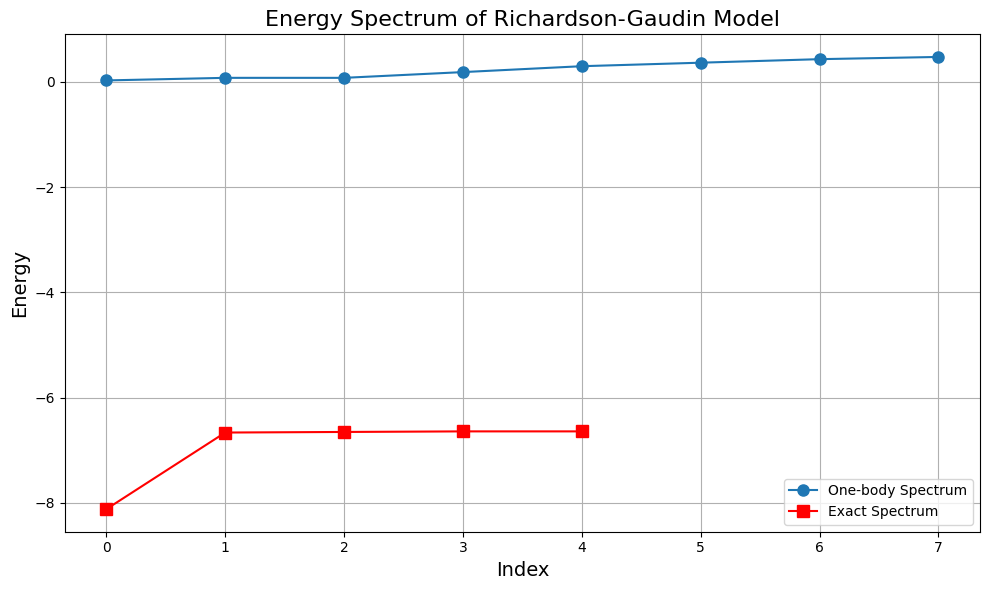

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_eigenvalues)), sorted_eigenvalues, 'o-', markersize=8, label='One-body Spectrum')
plt.plot(range(len(energies)), energies, 's-', markersize=8, color='red', label='Exact Spectrum')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Energy Spectrum of Richardson-Gaudin Model', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('rg_energy_spectrum.png')
plt.show()

## Part 2: Picket-Fence Richardson-Gaudin Model

Now, let's explore the picket-fence model. We will set up the Picket-Fence model with 8 sites and a level spacing of 1.0. The coupling strength $g$ will be set to 0.5.

### Step 1: Define Model Parameters
We start by defining the number of sites, level spacing, and coupling strength.

In [ ]:
n_sites_picket = 8
level_spacing = 1.0
g_picket = 0.5

# Generate the Zeeman term using evenly spaced levels (picket-fence)
mu_picket = np.arange(n_sites_picket) * level_spacing

# Create the coupling matrix with diagonal elements set to zero
J_eq_picket = np.full((n_sites_picket, n_sites_picket), g_picket)
np.fill_diagonal(J_eq_picket, 0)  # No self-interaction

# Create the Hamiltonian
ham_picket = HamRG(mu=mu_picket, J_eq=J_eq_picket)

# Generate the integrals
e0_picket = ham_picket.generate_zero_body_integral()
h1_picket = ham_picket.generate_one_body_integral(dense=True)
h2_picket = ham_picket.generate_two_body_integral(dense=True)

print("Energy levels (mu):\n", mu_picket)
print("\nCoupling matrix (J_eq):\n", J_eq_picket)
print("\nZero-body integral:", e0_picket)
print("One-body integral shape:", h1_picket.shape)
print("Two-body integral shape:", h2_picket.shape)

Energy levels (mu):
 [0. 1. 2. 3. 4. 5. 6. 7.]

Coupling matrix (J_eq):
 [[0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0. ]]

Zero-body integral: -14.0
One-body integral shape: (16, 16)
Two-body integral shape: (16, 16, 16, 16)


### Analyzing the Energy Spectrum of the Picket-Fence Model


Solving Picket-Fence model with PySCF FCI solver...

Error using PySCF: eri.size = 65536, norb = 8
Falling back to direct diagonalization...
Exact ground state energy: -29.50726257
Ground state energy per site: -3.68840782


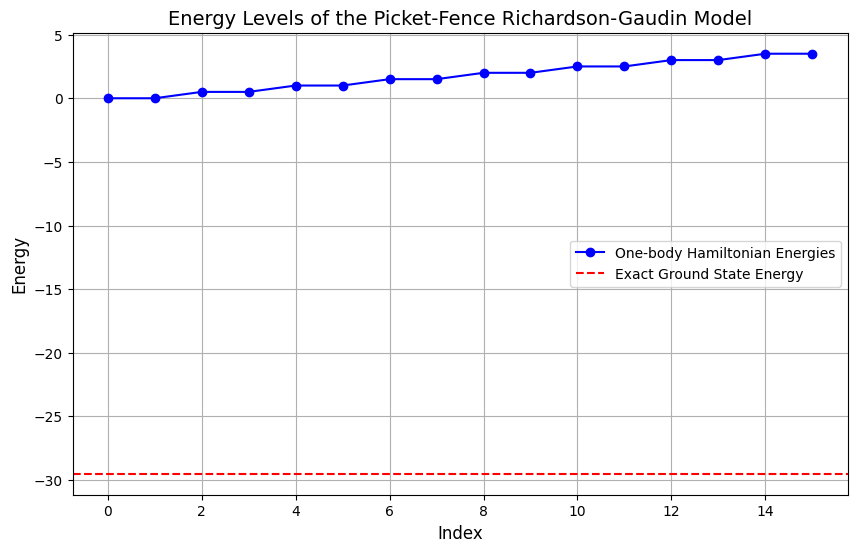

In [ ]:
eigenvals_picket = np.linalg.eigvals(h1_picket)
eigenvals_picket = np.sort(eigenvals_picket)

h2_picket_chemist = np.transpose(h2_picket, (0, 2, 1, 3))

try:
    print("\nSolving Picket-Fence model with PySCF FCI solver...")
    
    n_electrons = n_sites_picket // 2
    e_fci_picket, ci_fci_picket = fci.direct_spin0.kernel(h1_picket, h2_picket_chemist, n_sites_picket, n_electrons)
    
    # Total energy includes the zero-body term
    total_energy_fci_picket = e_fci_picket + e0_picket
    print(f"FCI ground state energy: {total_energy_fci_picket:.8f}")
    print(f"Ground state energy per site: {total_energy_fci_picket/n_sites_picket:.8f}")
    
    # Plot the energy spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals_picket, 'o-', label='One-body Hamiltonian Energies', color='blue')
    plt.axhline(y=total_energy_fci_picket, color='red', linestyle='--', label='PySCF FCI Ground State Energy')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title('Energy Levels of the Picket-Fence Richardson-Gaudin Model', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    use_pyscf = True
    
except Exception as e:
    print(f"\nError using PySCF: {e}")
    print("Falling back to direct diagonalization...")
    use_pyscf = False
    
    # Pauli spin matrices for direct diagonalization
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])
    
    # Create spin operators for each site
    Sx_picket = [spin_operator(sigma_x, i, n_sites_picket) for i in range(n_sites_picket)]
    Sy_picket = [spin_operator(sigma_y, i, n_sites_picket) for i in range(n_sites_picket)]
    Sz_picket = [spin_operator(sigma_z, i, n_sites_picket) for i in range(n_sites_picket)]
    
    # Construct the Hamiltonian explicitly
    H_picket = np.zeros((2**n_sites_picket, 2**n_sites_picket), dtype=complex)
    
    # Add Zeeman terms
    for i in range(n_sites_picket):
        H_picket += mu_picket[i] * Sz_picket[i]
    
    # Add interaction terms
    for i in range(n_sites_picket):
        for j in range(n_sites_picket):
            if i != j:  # Skip self-interactions
                # XY interaction (S+S-) = 0.5*(SxSx + SySy)
                H_picket += g_picket * (Sx_picket[i] @ Sx_picket[j] + Sy_picket[i] @ Sy_picket[j])
    
    # Calculate eigenvalues and eigenvectors
    exact_eigenvalues_picket, exact_eigenvectors_picket = eigh(H_picket)
    total_energy_fci_picket = exact_eigenvalues_picket[0].real  # Ground state energy
    
    print(f"Exact ground state energy: {total_energy_fci_picket:.8f}")
    print(f"Ground state energy per site: {total_energy_fci_picket/n_sites_picket:.8f}")
    
    # Plot the energy levels as in picketf.py
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals_picket, 'o-', label='One-body Hamiltonian Energies', color='blue')
    plt.axhline(y=total_energy_fci_picket, color='red', linestyle='--', label='Exact Ground State Energy')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title('Energy Levels of the Picket-Fence Richardson-Gaudin Model', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()



### Phase Transitions in the Picket-Fence Model

We will now explore the phase transitions in the Picket-Fence Richardson-Gaudin model by varying the coupling strength $g$.

Let's vary the coupling strength from 0.1 to 2.0 and observe the changes in the ground state energy.


Diagnostic Data for Phase Transitions Analysis:
----------------------------------------------------------------------
   g_value |  Zero-Body | Min One-Body | One-Body Total |      Exact
----------------------------------------------------------------------
      0.10 |   -14.0000 |       0.0000 |       -13.0000 |   -28.1439
      0.20 |   -14.0000 |       0.0000 |       -13.0000 |   -28.4310
      0.30 |   -14.0000 |       0.0000 |       -13.0000 |   -28.7702
      0.40 |   -14.0000 |       0.0000 |       -13.0000 |   -29.1326
      0.50 |   -14.0000 |       0.0000 |       -13.0000 |   -29.5073
      0.60 |   -14.0000 |       0.0000 |       -13.0000 |   -29.8890
      0.70 |   -14.0000 |       0.0000 |       -13.0000 |   -30.2753
      0.80 |   -14.0000 |       0.0000 |       -13.0000 |   -30.8095
      0.90 |   -14.0000 |       0.0000 |       -13.0000 |   -31.5623
      1.00 |   -14.0000 |       0.0000 |       -13.0000 |   -32.3225
      1.10 |   -14.0000 |       0.0000 |       -13

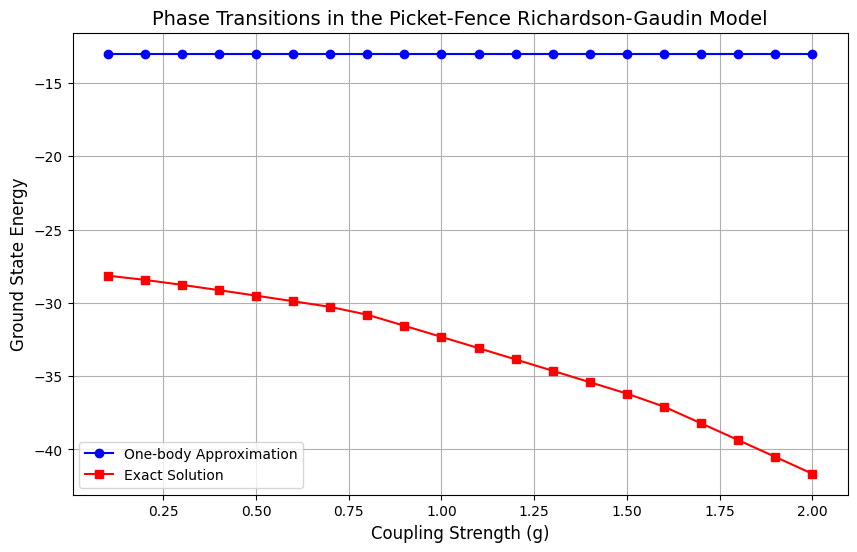

In [ ]:
g_values = np.linspace(0.1, 2.0, 20)
ground_state_energies = []  # One-body approximation
exact_ground_energies = []  # Exact diagonalization
zero_body_terms = []        # zero-body terms
one_body_min_eigs = []      # minimum eigenvalues of one-body

print("\nDiagnostic Data for Phase Transitions Analysis:")
print("-" * 70)
print(f"{'g_value':>10s} | {'Zero-Body':>10s} | {'Min One-Body':>12s} | {'One-Body Total':>14s} | {'Exact':>10s}")
print("-" * 70)

# Create spin operators once to be reused
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

# Create spin operators for each site
Sx_picket = [spin_operator(sigma_x, i, n_sites_picket) for i in range(n_sites_picket)]
Sy_picket = [spin_operator(sigma_y, i, n_sites_picket) for i in range(n_sites_picket)]
Sz_picket = [spin_operator(sigma_z, i, n_sites_picket) for i in range(n_sites_picket)]

for g_val in g_values:

    J_eq_g = np.full((n_sites_picket, n_sites_picket), g_val)
    np.fill_diagonal(J_eq_g, 0)  # No self-interaction
    
    # a new Hamiltonian with this specific coupling strength
    ham_g = HamRG(mu=mu_picket, J_eq=J_eq_g)
    
    # One-body approximation
    h1_g = ham_g.generate_one_body_integral(dense=True)
    e0_g = ham_g.generate_zero_body_integral()
    eigenvals_g = np.sort(np.linalg.eigvals(h1_g))
    
    # Store minimum eigenvalue for debugging
    min_eig = np.min(eigenvals_g)
    one_body_min_eigs.append(min_eig)
    zero_body_terms.append(e0_g)
    
    # Sum the lowest n_electrons eigenvalues and add zero-body term
    one_body_energy = np.sum(eigenvals_g[:n_electrons]) + e0_g
    ground_state_energies.append(one_body_energy)
    
    H_g = np.zeros((2**n_sites_picket, 2**n_sites_picket), dtype=complex)
    
    # Add Zeeman terms (these don't depend on g)
    for i in range(n_sites_picket):
        H_g += mu_picket[i] * Sz_picket[i]
    
    # Add interaction terms with the specific g_val
    for i in range(n_sites_picket):
        for j in range(n_sites_picket):
            if i != j:  # Skip self-interactions
                # XY interaction (S+S-) = 0.5*(SxSx + SySy)
                H_g += g_val * (Sx_picket[i] @ Sx_picket[j] + Sy_picket[i] @ Sy_picket[j])
    
    # Calculate eigenvalues and get ground state energy
    exact_eigenvalues_g = np.linalg.eigvalsh(H_g)
    exact_ground_energy = np.min(exact_eigenvalues_g.real)
    exact_ground_energies.append(exact_ground_energy)
    
    # Print infos
    print(f"{g_val:10.2f} | {e0_g:10.4f} | {min_eig:12.4f} | {one_body_energy:14.4f} | {exact_ground_energy:10.4f}")

print("\nImproved data arrays for plotting (varying with g):")
print("g_values =", g_values)
print("ground_state_energies (one-body) =", ground_state_energies)
print("exact_ground_energies =", exact_ground_energies)

# Plot the ground state energy as a function of coupling strength
plt.figure(figsize=(10, 6))
plt.plot(g_values, ground_state_energies, 'o-', label='One-body Approximation', color='blue')
plt.plot(g_values, exact_ground_energies, 's-', label='Exact Solution', color='red')
plt.xlabel('Coupling Strength (g)', fontsize=12)
plt.ylabel('Ground State Energy', fontsize=12)
plt.title('Phase Transitions in the Picket-Fence Richardson-Gaudin Model', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()